pybaseball github with install instructions: https://github.com/jldbc/pybaseball <br>
Documentation for pybaseball library: https://github.com/jldbc/pybaseball/tree/master/docs <br>
Statcast header meanings: https://baseballsavant.mlb.com/csv-docs

plate_x
Horizontal position of the ball when it crosses home plate from the catcher's perspective.

plate_z
Vertical position of the ball when it crosses home plate from the catcher's perspective.

In [1]:
import pybaseball
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
def pitcher(last_name, first_name):
    pitcher = pybaseball.playerid_lookup(last_name, first_name)
    return pitcher

In [3]:
def games_pitched_in_timeframe(first_name, last_name, start_date, end_date):
    l_name = last_name
    f_name = first_name
    pitcher_data = pitcher(l_name, f_name)
    pitcher_id = str(pitcher_data['key_mlbam'][0])
    pitching_data = pybaseball.statcast_pitcher(start_date, end_date, pitcher_id)
    dates = list(Counter(pitching_data['game_date']))
    clean_period = []
    for x in dates:
        date_split = x.split('-')
        day = date_split[2]
        if day[0] == '0':
            day = day[1]
            date_split[2] = day
        date_clean = '-'.join(date_split)
        clean_period.append('-'.join(date_split))
    return clean_period

In [4]:
def pitcher_game_number(dates, team):
    months = {'Jan' : '01', 'Feb' : '02', 'Mar' : '03', 'Apr' : '04', 'May' : '05', 'Jun' : '06',
          'Jul' : '07', 'Aug': '08', 'Sep' : '09', 'Oct' : '10', 'Nov' : '11', 'Dec' : '12'}
    
    game_dates = []
    for x in dates:   
        game_date = x.split('-')
        year = game_date[0]
        game_date = game_date[1:]
        game_dates.append('-'.join(game_date))        
    
    pitching_logs = pybaseball.team_game_logs(year, team, "pitching")
    test = list(pitching_logs['Date'])
    test = [i.split() for i in test]
    x = 0
    for ind in test:
        ind[0] = months.get(ind[0])
        new_string = '-'.join(ind)
        test[x] = new_string
        x+=1
    pitching_logs['Date'] = test
    
    game_ids = []
    data = pybaseball.statcast(dates[0], dates[-1])
    
    for x in range(len(dates)):
        game = pitching_logs.loc[pitching_logs['Date'] == game_dates[x]].reset_index()
        game_data = data.loc[data['game_date'] == dates[x]]
        if game['Home'][0] == True:
            pitcher_game_data = game_data.loc[game_data['away_team'] == 'LAD']
            game_pk = list(pitcher_game_data['game_pk'])
            game_ids.append(game_pk[0])
        else:
            pitcher_game_data = game_data.loc[game_data['home_team'] == 'LAD']
            game_pk = list(pitcher_game_data['game_pk'])
            game_ids.append(game_pk[0])

    return game_ids

In [5]:
# Single game stats
def pitcher_game_complete_data(game_id, pitcher_id):
    data = pybaseball.statcast_single_game(game_id).reset_index(drop = True)
    pitcher_data = pd.DataFrame()
    for x in range(len(data)):
        if data['pitcher'][x] == pitcher_id:
            pitcher_data = pitcher_data.append(data.iloc[[x]])
    pitcher_data = pitcher_data.reset_index(drop = True)
    return pitcher_data

In [6]:
# Breakdown of the pitches throw in the time period
def pitch_summary(game_data):
    data = Counter(game_data['pitch_type'])
    return data

In [7]:
# Seperate the balls, stikes, and live balls in play
def ball_and_strike(game_data):
    balls = pd.DataFrame(columns = ['pitch_type', 'description'])
    strikes = pd.DataFrame(columns = ['pitch_type', 'description'])
    live = pd.DataFrame(columns = ['pitch_type', 'description'])
    k = 0
    for x in range(len(game_data)):
        if game_data['description'][x] == 'ball':
            details = game_data[['pitch_type','description', 'plate_x', 'plate_z']].iloc[[x]]
            balls = balls.append(details)
        elif game_data['description'][x] == 'hit_into_play':
            details = game_data[['pitch_type','description', 'plate_x', 'plate_z']].iloc[[x]]
            live = live.append(details)
        else:
            details = game_data[['pitch_type','description', 'plate_x', 'plate_z']].iloc[[x]]
            strikes = strikes.append(details)
    return balls, strikes, live

In [8]:
# Display the pitching data for the time period in a scatter plot color coded by strike, ball or live ball in play
def pitch_graph(pitching_breakdowns, start_date, end_date):
    pitch_ball = pitching_breakdowns[0]
    balls_xs = [x for x in pitch_ball['plate_x'].reset_index(drop = True)]
    balls_zs = [x for x in pitch_ball['plate_z'].reset_index(drop = True)]
    balls_colors = ['blue' for x in range(len(balls_xs))]

    pitch_strike = pitching_breakdowns[1]
    strikes_xs = [x for x in pitch_strike['plate_x'].reset_index(drop = True)]
    strikes_zs = [x for x in pitch_strike['plate_z'].reset_index(drop = True)]
    strikes_colors = ['red' for x in range(len(strikes_xs))]

    pitch_hit = pitching_breakdowns[2]
    hit_xs = [x for x in pitch_hit['plate_x'].reset_index(drop = True)]
    hit_zs = [x for x in pitch_hit['plate_z'].reset_index(drop = True)]
    hit_colors = ['green' for x in range(len(hit_xs))]


    xs = strikes_xs + balls_xs + hit_xs
    zs = strikes_zs + balls_zs + hit_zs
    colors = strikes_colors + balls_colors + hit_colors
    
    plt.title('All Pitches Thrown between ' + start_date + ' and ' + end_date)
    plt.scatter(xs,zs,color = colors)
    plt.show()

In [9]:
def main(first_name, last_name, start_date, end_date, team):
    desired_pitcher = pitcher(last_name, first_name)
    desired_pitcher_id = desired_pitcher['key_mlbam'][0]
    
    games = games_pitched_in_timeframe(first_name, last_name, start_date, end_date)
    
    game_id = pitcher_game_number(games, team)
    
    game_pitch_data = pd.DataFrame()
    for x in game_id:
        game_pitch_data = game_pitch_data.append(pitcher_game_complete_data(x, desired_pitcher_id))
    game_pitch_data = game_pitch_data.iloc[::-1].reset_index(drop = True)
    
    pitching_dates = games_pitched_in_timeframe(first_name, last_name, start_date, end_date)
    pitch_breakdown_in_timeframe = pitch_summary(game_pitch_data)
    
    #     summary stats at the top
    print(first_name, last_name)
    print(start_date + ' through ' + end_date)
    print('Total Games Pitched: ' + str(len(pitching_dates)))
    print('Dates Player Pitched: ' + str(pitching_dates))
    print('Pitch Brekdown for Time Period: ' + str(pitch_breakdown_in_timeframe))
    
    pitch_breakdowns = ball_and_strike(game_pitch_data)
    pitch_graph(pitch_breakdowns, start_date, end_date)

Gathering player lookup table. This may take a moment.
Gathering Player Data
This is a large query, it may take a moment to complete


C:\Users\matth\anaconda3\lib\site-packages\pybaseball\statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:09<00:00,  5.57it/s]


Gathering Player Data
clayton kershaw
2017-06-1 through 2017-07-31
Total Games Pitched: 10
Dates Player Pitched: ['2017-07-23', '2017-07-18', '2017-07-9', '2017-07-4', '2017-06-29', '2017-06-24', '2017-06-19', '2017-06-13', '2017-06-7', '2017-06-2']
Pitch Brekdown for Time Period: Counter({'FF': 390, 'SL': 348, 'CU': 188, 'FT': 15, 'CH': 6})


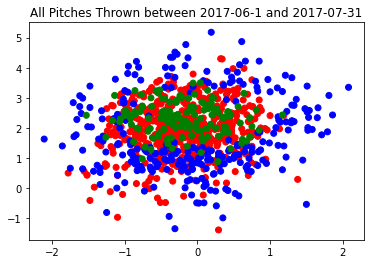

In [10]:
main('clayton','kershaw','2017-06-1','2017-07-31', 'LAD')